In [1]:
import time
start_time=time.time()

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import lmfit
from scipy import interpolate
import pickle

from bfunc import bfunc00,bfunc01,bfunc02

Data load and region parameters

In [3]:
name = 'OrionS'

In [4]:
reg = 'OrionS'

In [5]:
pickle_in = open('SFresults//' + name + '.pkl',"rb")
SFresults = pickle.load(pickle_in)

In [6]:
B = SFresults['b2']
r = SFresults['s']
s0 = SFresults['s0']   
m = SFresults['m'] 
sig2 = SFresults['sig2'] 
r0 = SFresults['r0'] 
noise = B.mean()*0.05

In [7]:
model02 = lmfit.Model(bfunc02)
model02.param_names

['r0', 'sig2', 'm', 's0', 'noise']

In [8]:
relative_uncertainty = 0.15
weights = 1.0 / (relative_uncertainty * B)
weights[r > r0] /= 2.0

In [9]:
for p in model02.param_names:
    model02.set_param_hint(p, min=0.0)
#model02.set_param_hint("sig2", value=sig2, vary=False)
#model02.set_param_hint("s0", min=0.2)
model02.print_param_hints()

Name      Value      Min      Max     Vary    Expr    
m           nan        0      inf     True    
noise       nan        0      inf     True    
r0          nan        0      inf     True    
s0          nan        0      inf     True    
sig2        nan        0      inf     True    


In [10]:
result2 = model02.fit(
    B, 
    weights=weights,
    r = r, r0 = r0, m = m, s0 = s0, noise = noise, sig2=sig2,
)

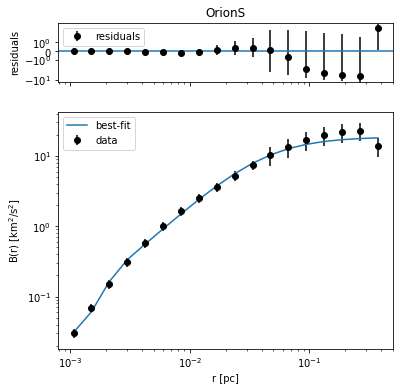

In [11]:
fig, _ = result2.plot( 'ko')
fig.axes[0].set(
    title=reg,
    xscale="log",
    yscale="symlog",
)
fig.axes[1].set(
    xscale = "log",
    yscale = "log",
    xlabel = "r [pc]",
    ylabel = r"B(r) [km$^{2}$/s$^{2}$]",
);

plt.savefig('Imgs//SF//' + reg + '.pdf', bbox_inches='tight')



In [12]:
CIresults = {'resultCI' : result2,
            'Rmax/r0' : r.max()/result2.params['r0'].value,
            'lT' : (r[3]/2**0.5)*((result2.params['r0'].value/r[3])**(result2.params['m'].value/2))
          }

In [13]:
f = open('CIresults//' + name +'.pkl',"wb")
pickle.dump(CIresults,f)
f.close()

In [14]:
print(result2.fit_report())

[[Model]]
    Model(bfunc02)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 55
    # data points      = 18
    # variables        = 5
    chi-square         = 5.20011576
    reduced chi-square = 0.40000890
    Akaike info crit   = -12.3504357
    Bayesian info crit = -7.89857689
[[Variables]]
    r0:     0.04132245 +/- 0.00528318 (12.79%) (init = 0.04305689)
    sig2:   9.34424723 +/- 0.96290443 (10.30%) (init = 9.375507)
    m:      1.54701154 +/- 0.06192076 (4.00%) (init = 1.5)
    s0:     9.2606e-04 +/- 6.9989e-05 (7.56%) (init = 0.0007596444)
    noise:  0.02432530 +/- 0.00361055 (14.84%) (init = 0.3919269)
[[Correlations]] (unreported correlations are < 0.100)
    C(r0, sig2)  =  0.893
    C(r0, m)     = -0.828
    C(s0, noise) =  0.583
    C(m, s0)     = -0.579
    C(sig2, m)   = -0.554
    C(r0, s0)    =  0.365
    C(sig2, s0)  =  0.225


In [15]:
for p in result2.model.param_names:
    result2.params[p].stderr = result2.params[p].value * 0.1

In [16]:
result2.conf_interval()
print(result2.ci_report())

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:312: UserWarning: Bound reached with prob(noise=0.0) = 0.9946017301969445 < max(sigmas)
  warn(errmsg)


          99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 r0   :  -0.01596  -0.01038  -0.00524   0.04132  +0.00610  +0.01443  +0.02843
 sig2 :  -3.24520  -2.03499  -0.99105   9.34425  +1.05555  +2.33225  +4.11303
 m    :  -0.24054  -0.14296  -0.06729   1.54701  +0.06822  +0.14723  +0.25283
 s0   :  -0.00044  -0.00020  -0.00009   0.00093  +0.00009  +0.00020  +0.00035
 noise:      -inf  -0.01061  -0.00444   0.02433  +0.00397  +0.00813  +0.01310


In [17]:
plt.style.use([
    "seaborn-poster",
])

In [18]:
plot_limits = {
    "s0": [0.0, 0.1],
    "m": [.5, .5],
    "r0": [0.1, 1.0],
    "noise": [0.0, 0.5],
}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plt.title('M8')
levels = [0.6827, 0.9545, 0.9973]
colors = ["g", "y", "r"]

for ax, [xvar, yvar] in zip(axes.flat, [
    ["s0", "noise"],
    ["r0", "m"],
    ["m", "s0"],
    ["r0", "s0"],
]):
    cx, cy, grid = lmfit.conf_interval2d(
        result2, result2, xvar, yvar, 30, 30,
        limits=[plot_limits[xvar], plot_limits[yvar]],
    )
    ctp = ax.contour(cx, cy, grid, levels, colors=colors)
    ax.set_xlabel(xvar)
    ax.set_ylabel(yvar)

fig.tight_layout();

In [19]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 7.232732534408569 seconds ---
